In [1]:
from qiskit_dynamics import DynamicsBackend, Solver
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import BackendEstimator
from custom_jax_sim import JaxSolver, DynamicsBackendEstimator
import numpy as np
from helper_functions import perform_standard_calibrations
from qiskit_dynamics.array import Array
import jax

jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
Array.set_default_backend("jax")

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
# define the system
dim = 3

v0, v1 = 4.86e9, 4.97e9
anharm0, anharm1 = -0.32e9, -0.32e9
r0, r1 = 0.22e9, 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0, N1 = np.kron(ident, N), np.kron(N, ident)
a0, a1 = np.kron(ident, a), np.kron(a, ident)
a0dag, a1dag = np.kron(ident, adag), np.kron(adag, ident)

static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = (
    static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))
)

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

# build solver
dt = 1 / 4.5e9

solver_2q_jax = JaxSolver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
)
solver_2q = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
)
# Consistent solver option to use throughout notebook

solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}
solver = solver_2q_jax
custom_backend = DynamicsBackend(
    solver=solver,
    # target = fake_backend_v2.target,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options,  # to be used every time run is called
)

In [3]:
cals, results = perform_standard_calibrations(backend=custom_backend)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'t', 'tdg', 's', 'measure', 'sx', 'delay', 'h', 'x', 'rz', 'reset', 'id', 'sdg', 'z'}
  q1: {'t', 'tdg', 's', 'measure', 'sx', 'delay', 'h', 'x', 'rz', 'reset', 'id', 'sdg', 'z'}
Multi qubit instructions:
  (0, 1): {'cr45p', 'cr45m', 'ecr'}
  (1, 0): {'cr45p', 'cr45m', 'ecr'}
)>


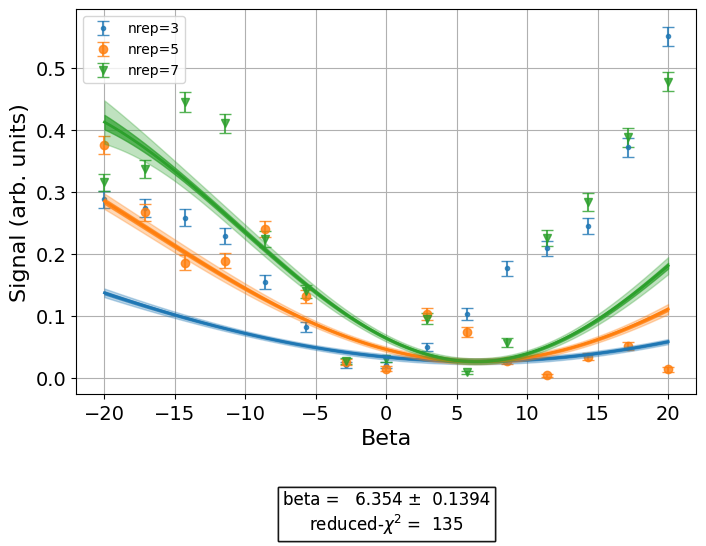

In [4]:
results[0][1].figure(0)

In [5]:
observable = SparsePauliOp.from_list([("IZ", 1.0)])
estimator = BackendEstimator(backend=custom_backend)
dynamicsestimator = DynamicsBackendEstimator(backend=custom_backend)

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


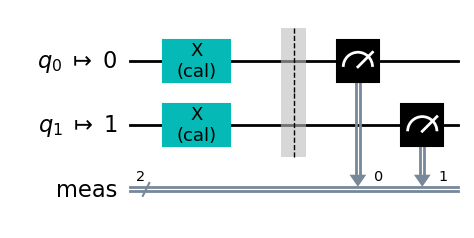

In [6]:
from qiskit import transpile

qc = QuantumCircuit(2)
qc.x(0)
qc.x(1)
qc.measure_all()
qc = transpile(qc, custom_backend)
qc.draw("mpl")

In [7]:
custom_backend.run(qc, shots=1000).result().get_counts()

{'01': 4, '10': 36, '11': 960}

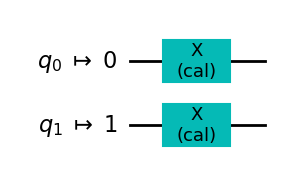

In [8]:
qc.remove_final_measurements(inplace=False).draw("mpl")

In [9]:
estimator.run(
    qc.remove_final_measurements(inplace=False), observable, shots=1000
).result()

EstimatorResult(values=array([-0.936]), metadata=[{'variance': 0.1239039999999999, 'shots': 1000}])

In [10]:
from qiskit import schedule as build_schedule


def get_schedule(qc, backend):
    def macro():
        return build_schedule(qc, backend)

    return macro

In [11]:
solver_2q_jax.circuit_macro = get_schedule(qc, custom_backend)
dynamicsestimator.run(
    qc.remove_final_measurements(inplace=False), observable, shots=1000
).result()

EstimatorResult(values=array([-0.94]), metadata=[{'variance': 0.11640000000000006, 'shots': 1000}])